# Predicting SalePrice

## Objectives

Create and evaluate model to predict SalePrice of building

## Inputs:
* outputs/datasets/cleaned/test.parquet.gzip
* outputs/datasets/cleaned/train.parquet.gzip
* Conclusions from Feature Engineering jupyter_notebooks/04_Feature_Engineering.ipynb

## Outputs
* Train Set: Features and Target
* Test Set: Features and Target
* Feature Engineering Pipeline
* Modeling Pipeline
* Features Importance Plot

## Change working directory
In This section we will get location of current directory and move one step up, to parent folder, so App will be accessing project folder.

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os

from feature_engine.transformation import BoxCoxTransformer

current_dir = os.getcwd()
current_dir

'/Users/pecukevicius/DataspellProjects/heritage_houses_p5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chdir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("you have set a new current directory")

you have set a new current directory


Confirm new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/Users/pecukevicius/DataspellProjects/heritage_houses_p5'

## Loading Dataset

In [4]:
import pandas as pd

df_train = pd.read_parquet('outputs/datasets/cleaned/train.parquet.gzip')
df_train.head()
import pandas as pd

df_test = pd.read_parquet('outputs/datasets/cleaned/test.parquet.gzip')
df_train.head()

,Unnamed: 0,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
809,809,1075,1063,2,No,0,Unf,849,0,360,...,90,0,156,5,5,849,0,1898,1965,106000
608,608,1940,1254,4,Mn,428,BLQ,537,0,380,...,78,0,0,6,8,965,0,1934,1998,359100
1189,1189,1028,776,3,No,0,Unf,994,0,442,...,60,0,60,5,7,994,0,1999,1999,189000
1039,1039,630,0,1,Av,509,GLQ,121,0,286,...,21,0,0,4,4,630,0,1970,1970,80000
1297,1297,1072,0,2,Gd,547,GLQ,0,0,525,...,35,82,44,5,6,547,0,2005,2006,140000


## Data Exploration
Before exploring data and doing transformations, as we decided earlier, we drop features:

In [5]:
drop_features = ['Unnamed: 0', 'EnclosedPorch', 'WoodDeckSF']
df_train.drop(columns=drop_features, inplace=True)
df_test.drop(columns=drop_features, inplace=True)

In [6]:
df_train.columns.tolist()

['1stFlrSF',
 '2ndFlrSF',
 'BedroomAbvGr',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinType1',
 'BsmtUnfSF',
 'GarageArea',
 'GarageFinish',
 'GarageYrBlt',
 'GrLivArea',
 'KitchenQual',
 'LotArea',
 'LotFrontage',
 'MasVnrArea',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd',
 'SalePrice']

## Machine Learning

In [45]:
from feature_engine.outliers import Winsorizer
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np


# Define feature pipeline
def feature_pipeline(model):
    from feature_engine.encoding import OrdinalEncoder
    from feature_engine.transformation import LogTransformer, YeoJohnsonTransformer, PowerTransformer
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish',
                                                                'KitchenQual'])),
        ('LogTransformer', LogTransformer(variables=['GarageYrBlt', 'GrLivArea', 'YearBuilt', 'YearRemodAdd'])),
        ('YeoJohnsonTransformer', YeoJohnsonTransformer(
            variables=['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtFinType1', 'GarageFinish',
                       'LotArea', 'MasVnrArea', 'OpenPorchSF', 'OverallQual', 'TotalBsmtSF'])),
        ('PowerTransformer', PowerTransformer(variables=['BsmtFinSF1', 'BsmtUnfSF', 'KitchenQual'])),
        ("Winsorizer", Winsorizer(capping_method='iqr', tail='both', fold=1.5,
                                  variables=['GrLivArea'])),

        ("feat_scaling", StandardScaler()),

        ("feat_selection", SelectFromModel(model)),

        ("model", model),
    ])


    return pipeline_base



## ML Pipeline for Modeling and Hyperparameters Optimization

This is custom Class Hyperparameter Optimization

In [46]:
from sklearn.model_selection import GridSearchCV

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model =  feature_pipeline(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X,y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

### Splitting Sets to Features and targets

In [47]:
# Identify the target variable column name
target_column = 'SalePrice'

# Extract the target variable
y_train = df_train[target_column]
y_test = df_test[target_column]

# Remove the target variable from the DataFrame to create the feature DataFrame
X_train = df_train.drop(columns=[target_column])
X_test = df_test.drop(columns=[target_column])


### Grid Search CV

For this time being we will use default hyperparameters, just to select best algorithms

In [48]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

### Running Grid Search CV

### Results Inspection

In [49]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [50]:
import numpy as np

grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.770221,0.831497,0.867662,0.03615
4,AdaBoostRegressor,0.753996,0.817215,0.860985,0.035192
5,GradientBoostingRegressor,0.670061,0.813806,0.868058,0.072656
2,RandomForestRegressor,0.675916,0.781357,0.831919,0.0545
0,LinearRegression,0.744665,0.777116,0.806395,0.025654
6,XGBRegressor,0.649671,0.737544,0.797797,0.054235
1,DecisionTreeRegressor,0.607537,0.701661,0.803338,0.073766


We can see that GradientBoostingRegressor shows most promising results, mean = 0.831497
Now we will add extra HyperParameters

In [57]:
from xgboost import XGBRegressor

models_tune_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_tune_search = {
    "ExtraTreesRegressor": {
        'model__n_estimators': [100, 300],
        'model__max_depth': [3, 10, None],
        'model__min_samples_split': [8],
    }
}


In [58]:
search = HyperparameterOptimizationSearch(models=models_tune_search, params=params_tune_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [59]:

grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_split,model__n_estimators
2,ExtraTreesRegressor,0.77924,0.846216,0.872305,0.034732,10,8,100
3,ExtraTreesRegressor,0.777298,0.845951,0.870627,0.035421,10,8,300
5,ExtraTreesRegressor,0.785147,0.845493,0.869141,0.031359,None,8,300
4,ExtraTreesRegressor,0.786041,0.845196,0.869385,0.030925,None,8,100
1,ExtraTreesRegressor,0.702913,0.768716,0.819067,0.040686,3,8,300
0,ExtraTreesRegressor,0.701747,0.767326,0.822958,0.042022,3,8,100


Yay, we managed to increase mean from 0.832868 to 0.846216, not a lot but still something.

Selecting best model

In [60]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'ExtraTreesRegressor'

Parameters for best model

In [61]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': 10,
 'model__min_samples_split': 8,
 'model__n_estimators': 100}

In [62]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('LogTransformer',
                 LogTransformer(variables=['GarageYrBlt', 'GrLivArea',
                                           'YearBuilt', 'YearRemodAdd'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['1stFlrSF', '2ndFlrSF',
                                                  'BedroomA...
                 PowerTransformer(variables=['BsmtFinSF1', 'BsmtUnfSF',
                                             'KitchenQual'])),
                ('Winsorizer',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['GrLivArea'])),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(max_depth=10, min_samples_split=8,
                                     random_state=0))])

## Accessing Feature Importance

* These are the 5 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'KitchenQual', '1stFlrSF', 'TotalBsmtSF']


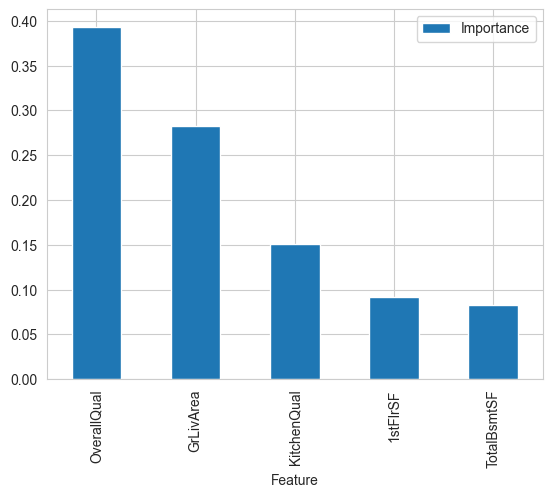

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# after data cleaning and feat engine, the feature may space changes
data_cleaning_feat_eng_steps = 5  # how many data cleaning and feature engineering the pipeline has
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
                         .sort_values(by='Importance', ascending=False)
                         )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

## Evaluating Model on Train and Test Sets

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    # Train plot
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0], color='blue')
    axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')  # Red line y=x
    axes[0].set_xlabel("Actual Values")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set Performance")

    # Test plot
    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1], color='green')
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Red line y=x
    axes[1].set_xlabel("Actual Values")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set Performance")

    plt.show()


Model Evaluation 

* Train Set
R2 Score: 0.929
Mean Absolute Error: 15141.322


* Test Set
R2 Score: 0.609
Mean Absolute Error: 25215.33




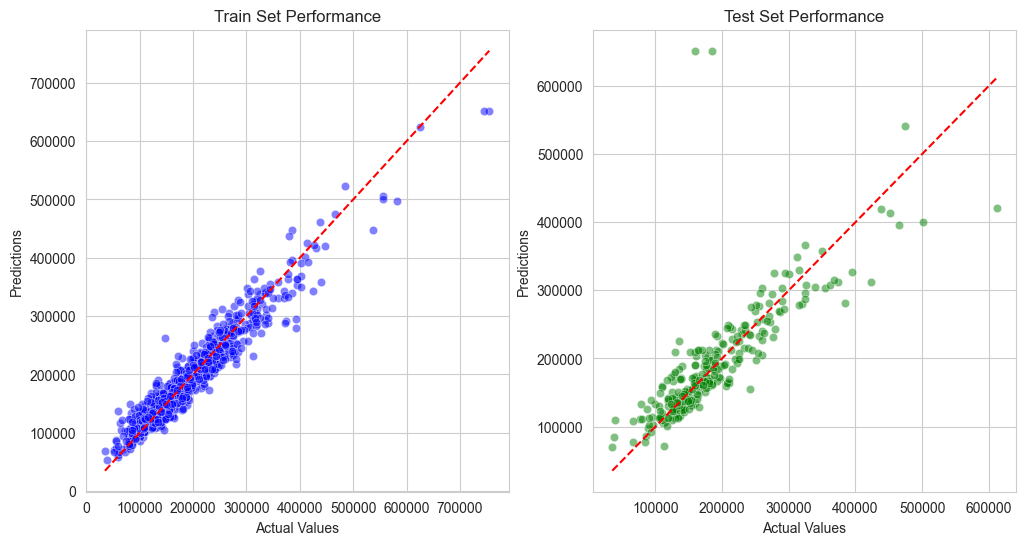

In [65]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

## This model is not accurate enough, as mean score of test is just 0.609

## Hypothesis 3: There Might be a combination of features to predict Sale Price.